In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numba import jit
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'sample_submission.csv']


<a id=1><pre><b>Import the Data</b></pre></a>

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print ("Data is ready!")

Data is ready!


In [3]:
print ("Test1 ",test.shape)
print ("Train1 ",train.shape)
train.sample(6)

Test1  (200000, 201)
Train1  (200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
12859,train_12859,0,15.1202,-7.1124,10.7039,4.7186,8.3271,2.1419,3.8630,13.1019,-0.5468,7.6447,-3.7413,-12.0935,14.1523,9.0277,10.5453,14.0009,5.9639,4.8368,3.2396,14.8300,5.8933,4.3368,5.0833,3.1587,7.6519,13.9186,-2.8715,-2.3968,5.6403,7.1088,-27.6300,12.1695,-1.8105,9.3803,11.7461,0.2752,11.8788,3.6427,...,39.8677,5.7340,4.2445,10.7378,-11.4163,14.8451,3.2601,-13.1321,7.5225,5.0042,1.6241,1.3074,23.8178,-3.3758,24.7219,11.5222,-5.2216,14.8828,7.0885,0.1092,7.6278,10.3738,-15.0168,5.0839,16.2990,-8.6350,8.9188,-5.9699,18.3506,0.4799,6.9454,1.3576,0.9168,9.9010,19.5246,0.4915,-5.1737,10.1863,16.7808,7.3255
153839,train_153839,0,6.5083,-2.9448,13.8594,4.4768,10.6823,3.1816,5.2209,22.5196,-2.0672,9.2327,8.5817,-5.7853,13.7026,5.7186,6.1416,14.4909,6.7592,3.5958,25.8645,26.1272,19.7993,17.8172,8.8075,3.0547,17.2364,13.8160,-7.2284,-1.0932,5.3539,4.3995,-16.7111,8.5602,2.1476,17.7302,11.1033,4.9478,1.9000,2.9876,...,35.2916,5.2847,8.2555,16.2580,-6.6021,28.1549,3.1486,-3.6749,5.7343,5.4426,2.8205,3.7480,19.8795,-1.7985,15.2525,9.3581,-10.1841,12.4992,13.0449,-1.4450,4.6457,13.5625,-5.1260,14.9436,3.2865,-4.2342,15.3409,-7.9721,16.4374,1.1266,6.9422,0.5041,1.1935,3.3009,25.1693,-1.1970,4.6683,10.1188,13.0672,-1.3768
97486,train_97486,0,14.3899,-0.9502,13.4416,7.5133,11.7734,-3.3822,5.4473,17.0297,1.6855,6.4046,10.9149,-5.6991,13.8277,8.9089,6.1211,15.2867,10.2189,-3.3510,13.8968,5.7607,23.7831,8.5375,-1.3304,3.2667,4.4407,13.3459,-5.4044,1.3336,3.5599,6.6820,-13.6755,7.6766,-5.8641,10.2222,11.3968,4.0213,-0.2292,4.0619,...,13.5247,5.7142,4.5292,9.0848,-0.0074,11.0780,2.0793,-15.3190,12.2147,5.7105,-5.0701,-5.2028,16.8924,1.4433,24.9362,6.8581,-7.4920,8.1990,-12.5400,-1.7565,8.5152,12.4529,0.4136,7.2251,7.7332,1.3319,14.9846,1.6841,15.4156,0.7902,3.6334,5.0657,0.7937,6.8129,19.0267,2.4998,1.3723,9.1050,18.3221,-3.3636
26128,train_26128,1,13.3327,-4.5943,8.0341,8.3686,12.6859,-6.1110,4.6192,15.6268,3.6531,5.7790,4.0032,-0.8217,13.6148,10.9944,5.0223,14.0165,9.8598,-0.6560,12.7148,9.2559,10.1700,7.9150,5.7637,2.3282,6.2591,13.6607,-11.7793,1.3618,7.1868,5.8080,-13.7777,12.6624,-4.1727,17.9095,11.4822,16.1961,-0.8141,7.5881,...,13.3345,5.9010,6.2982,20.7086,1.0176,20.4108,2.6540,7.4518,6.2180,5.2162,1.5511,1.6873,27.6064,-1.3456,11.4877,10.4497,-13.7561,16.3073,-9.8301,2.1690,1.9306,8.9442,8.3974,11.7728,18.2805,5.6688,2.6774,-24.3160,12.8959,0.5351,3.2797,10.1840,2.4013,-0.0573,17.8866,-1.3140,-2.7047,10.0129,21.9800,6.8867
141520,train_141520,1,12.5554,-4.2337,15.7071,5.5652,11.5649,10.2734,4.7741,16.7619,6.2971,6.3692,7.0327,-3.2136,13.6002,11.8616,5.2297,14.1739,9.3521,-6.4164,20.4558,6.3853,7.7231,12.8826,6.1833,2.2287,5.4088,13.5958,0.3966,-0.8295,6.0491,1.4880,-1.0168,11.0294,-2.2285,16.2106,12.1765,5.3322,1.1644,3.6757,...,26.9901,5.4128,6.2706,13.3607,4.7073,24.8450,2.8090,0.2522,8.7816,5.2805,-2.9991,-6.1328,23.3209,-7.8707,20.4091,16.1735,1.1098,8.4412,12.8352,5.7178,-6.6755,10.2082,-0.8012,14.3587,26.5441,-4.5327,10.1424,-4.4936,11.8021,0.6510,-4.9617,10.3946,1.6893,2.6876,19.1222,-1.8700,-0.1814,8.2967,22.5527,11.0891
191107,train_191107,0,4.5916,-3.6267,7.9545,7.3825,8.3103,12.3093,5.5396,21.2196,0.7282,7.6566,7.3176,1.9072,13.8731,10.5412,9.9555,14.1803,12.4644,-7.5912,25.4339,25.9146,17.4653,15.0072,3.8975,3.5178,15.2630,13.7911,-8.3757,0.6935,4.7739,9.0519,-4.6961,10.0850,-2.5645,20.3308,11.8926,15.7770,3.0609,7.5043,...,10.9886,5.99

In [4]:
train['target']= train['target'].map(lambda x: 1 if x==0 else 0)
train.sample(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
14308,train_14308,1,13.6158,0.1257,8.9393,9.2476,10.4079,-8.1278,5.2473,20.6030,-2.4378,5.7359,4.6616,-2.5495,13.8805,11.8230,9.8575,14.1801,8.5855,-14.3073,13.4456,23.5652,24.3693,8.3732,3.0052,3.1599,8.2068,13.2691,0.2574,-2.0577,4.9364,6.2925,-6.4742,10.8823,0.3933,13.9841,10.3113,6.1562,8.9390,6.9597,...,38.3132,5.4462,3.8502,6.5965,-9.2994,24.7684,2.7670,-3.8603,4.7646,5.9869,-3.7821,-0.0735,13.9695,-4.6625,22.9336,10.9953,3.0341,9.4320,8.4361,4.8321,-3.3300,10.9221,-4.4658,10.8897,10.7986,-6.0964,7.8358,1.9861,11.8229,-0.1539,-0.3178,9.0121,0.7892,3.4773,18.0328,0.2021,-0.2591,10.1735,10.8943,-3.9310
90797,train_90797,1,13.9353,4.3480,12.3663,4.9960,12.6294,2.0245,4.0423,12.7622,2.0279,8.4481,-7.2450,-9.3024,14.0238,12.7802,6.1709,14.5251,6.6026,1.7484,20.1048,16.7214,15.9105,21.5152,4.9065,2.9302,9.4959,13.5517,-12.4698,-2.2546,4.8902,2.8391,-5.2964,9.4595,-1.5384,8.1833,11.3478,8.0700,0.3822,6.8119,...,24.9526,5.4482,2.1002,15.5270,-3.1512,18.8244,2.5976,-14.7053,7.5928,5.8495,3.6884,0.3699,18.6890,3.3765,21.9213,12.2920,2.0202,16.2692,0.1863,-1.9513,3.3091,12.6417,13.3381,6.6583,16.1029,3.3640,7.2027,2.5442,19.0053,0.9178,2.5971,7.7821,0.8899,7.7573,17.6187,-0.5161,14.0884,9.1642,21.4585,-8.1106
39669,train_39669,1,12.5031,4.2688,9.5506,5.9582,8.8943,-0.9485,5.6403,10.8705,5.7787,6.0719,3.8237,-0.7429,13.8500,13.8004,10.8630,15.0950,8.7473,-11.8827,27.8009,18.1990,6.6404,18.3180,5.8092,2.5344,5.7615,13.6880,4.4815,-0.6005,5.5462,1.5721,5.1671,7.3032,-2.8899,10.5437,11.4159,9.5277,0.6361,1.5187,...,23.5420,5.7754,4.7322,16.6753,9.1740,21.8667,2.2971,1.3609,6.9160,5.4601,-2.8006,-7.4247,26.0982,11.6746,14.6078,10.1225,-4.7854,14.3032,-10.8702,5.1599,-11.7223,10.2945,-3.4955,14.8591,24.0030,-9.7695,8.2956,-2.9119,17.5420,0.2949,7.6294,10.0648,2.3209,13.2280,16.2651,-1.5313,4.8341,9.8362,19.7720,10.1442
51028,train_51028,1,13.0719,-2.2876,13.4814,6.3772,12.3124,-0.9803,6.3238,16.8232,-2.7340,5.9808,-1.2455,-8.5439,14.1228,4.4173,10.9163,14.6820,11.5267,-8.3680,5.7886,-0.0063,15.5753,9.3173,2.7732,2.4185,8.4481,13.3936,-14.5125,-0.6097,5.2706,6.1248,3.0337,9.3893,2.1581,12.3195,11.5388,-3.4795,3.1060,3.8554,...,22.7045,5.2180,6.6875,6.2156,-3.1710,24.7408,2.8415,-7.9346,3.7716,5.8603,4.5246,3.4619,30.7765,-5.2012,13.0138,8.4458,3.8294,8.6740,-5.5989,3.9954,-0.2117,7.6057,-1.3335,5.2003,37.2999,-7.7099,11.9999,-11.6699,13.5704,0.1805,11.0309,8.5804,0.5288,4.7194,16.2624,-0.1671,0.6628,9.1090,16.8929,-12.8496
48468,train_48468,1,12.2991,-6.4393,15.3280,8.3169,12.6606,0.5822,5.7387,15.1731,1.3061,9.4294,7.8246,5.0013,13.9892,16.6063,8.5934,14.2467,8.4025,-5.8574,12.0982,1.4613,7.5424,16.0499,2.7832,3.7897,4.3427,13.5975,-1.5336,-0.3449,5.6289,0.4844,-7.3184,5.1221,1.3771,20.6532,10.8809,6.9290,0.1547,4.9981,...,37.9758,5.7524,4.9209,2.8094,-1.5029,14.4027,2.8761,3.3627,2.9494,5.3579,-8.0229,6.1485,27.5437,-4.9753,27.8673,5.5524,-14.3980,13.6862,-15.3876,4.4321,-7.8736,8.7918,1.7847,15.1702,11.3813,3.0029,7.4733,-20.1992,18.5189,0.9626,1.6187,9.1515,1.4412,-5.0963,20.8652,-1.3880,7.2755,9.7288,15.8546,-20.2341
31268,train_31268,1,11.0493,-3.4320,9.0332,5.6018,10.2945,-11.9519,3.0899,18.4031,2.8014,7.1276,5.8456,0.4381,13.8278,8.5032,9.9020,15.0604,12.2821,-10.9708,21.9764,22.0241,24.9659,11.7917,4.1578,2.4351,8.1082,13.7964,-2.7181,1.1989,5.1230,6.7384,-7.5976,12.9631,2.7328,10.4282,11.3157,1.4407,4.7646,9.0673,...,22.8965,5.3303,6.6501,23.10

In [5]:
from sklearn.utils import shuffle
train = shuffle(train)
train.tail(15)
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']


**Target = 0 or Target = 1, binary classification**

In [6]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.899510,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

Let's see basic stats on the 2 different groups.

In [7]:
train[train['target']==0].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20098.0,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,...,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,0.0,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,7.409064,0.357916,-2.834888,13.984464,7.764618,7.495020,14.594414,9.395369,-5.679385,16.265343,12.708704,12.968654,15.823715,4.821429,2.979384,10.906222,13.678882,-2.949112,-1.140560,5.476866,5.090517,-7.672537,10.227496,-0.276639,14.200831,11.348866,4.409162,1.828816,5.920623,10.654546,...,24.092142,5.636010,5.501557,11.502983,-2.202475,18.477984,2.899436,-3.432649,5.068286,5.582531,0.630093,-0.592465,18.831534,0.072190,18.893971,11.828309,-2.631667,11.592995,-1.519278,3.010162,-2.250702,10.141805,0.526091,8.695892,14.103659,-3.982510,8.679957,-9.819989,14.975745,0.772981,3.998064,7.864560,1.738266,3.120260,17.779568,-0.021130,2.688583,8.810815,15.393283,-2.532243
std,0.0,3.270293,4.220638,2.841075,2.070898,1.649266,8.140281,0.922442,3.421365,3.340028,1.278709,5.515060,6.083536,0.207935,4.888186,2.246319,0.418237,2.605433,6.677587,8.179688,8.128723,5.908411,8.578688,3.067136,0.535207,3.836304,0.290182,6.446004,1.532760,0.803272,2.633303,7.943894,2.154552,2.651428,4.457194,0.560916,5.327264,3.203155,2.276233,4.297554,...,10.925673,0.218979,1.470759,5.541083,5.655892,5.302411,0.394379,8.029430,3.204134,0.382246,4.694040,5.498356,8.966886,6.131035,7.623027,2.966222,7.583376,2.694812,8.687718,3.041853,5.487079,1.399232,8.982184,4.509661,9.702796,4.721488,3.235419,11.676023,4.104278,0.979948,4.814830,3.210779,1.482537,4.067550,3.193153,1.485975,5.556892,0.952554,3.248123,10.435910
min,0.0,0.452800,-14.037000,2.946200,0.374000,5.876200,-28.246100,2.496000,7.302400,-9.839100,4.186100,-18.386600,-23.707100,13.499400,-4.966100,1.013300,13.287000,1.369900,-28.086100,-6.587000,-12.402500,-1.625800,-8.005400,-5.322500,1.538600,0.238200,12.782000,-23.281000,-5.599200,3.092900,-4.019700,-31.692900,2.634600,-8.084300,2.111100,9.907600,-14.591800,-7.383700,-0.585300,-6.337100,...,-4.364200,4.941800,0.623100,-5.002100,-17.835800,4.275500,1.977200,-31.216400,-4.277600,4.539500,-13.724900,-18.708600,-9.455300,-21.397200,-2.037100,3.914900,-25.254500,5.261200,-24.957600,-7.137600,-19.493600,5.637900,-23.125000,-4.808200,-15.139200,-20.223100,-2.018300,-47.753600,4.535900,-2.311700,-11.906900,-2.343000,-3.317700,-11.783400,10.120700,-5.018500,-14.020400,6.119000,6.558700,-38.852800
25%,0.0,8.695875,-4.203475,8.961125,5.314300,9.911250,-10.61580

In [8]:
train[train['target']==1].describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.0,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.00000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,1.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,7.584907,0.398410,-3.291479,14.028392,8.615764,7.542364,14.570748,9.326326,-5.698669,15.129914,12.408389,13.326894,17.418103,4.247785,3.024026,10.548447,13.666224,-4.178694,-1.137611,5.539248,5.04978,-7.689438,10.411541,-0.539278,14.838196,11.443788,3.779194,2.227270,5.863121,10.640744,...,24.277974,5.632989,5.347406,10.946221,-2.946693,19.409346,2.970474,-4.231423,4.922471,5.641983,-0.075908,-0.858512,19.927197,-0.761772,20.357774,11.619644,-2.818344,11.915324,-0.957623,2.544666,-2.796515,10.079230,0.740672,8.777265,12.606196,-3.983345,9.002707,-10.392583,15.422021,0.743065,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,0.0,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,1.228839,5.499197,5.955722,0.187441,4.603038,2.248042,0.410909,2.551915,6.716530,7.805564,7.981264,5.871569,8.137105,2.816560,0.525768,3.768895,0.284984,5.847831,1.522704,0.780864,2.61397,7.967595,2.159704,2.579291,4.302266,0.538577,5.158947,3.107991,2.246682,4.276824,...,10.875049,0.217820,1.412943,5.226997,5.430098,4.983414,0.366132,7.767637,3.094492,0.367496,4.387806,5.363749,8.633896,5.942170,7.064789,2.883026,7.505930,2.619443,8.565845,2.766575,5.232564,1.368631,8.961104,4.470965,9.262205,4.725591,3.182983,11.561942,3.923825,0.975902,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,1.0,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.169000,13.076900,0.635100,-33.380200,-10.664200,-11.557600,-5.432200,-10.089000,-5.164000,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.78720,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-5.908200,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.676100,-18.489700,-22.583300,-3.022300,-46.598100,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600

**Missing data**

In [9]:
print ("Missing data at training")
train.isnull().values.any()

Missing data at training


False

In [10]:
print ("Missing data at test")
test.isnull().values.any()

Missing data at test


False

**There is no missing data**

In [11]:
train = train.drop(["ID_code", "target"], axis=1)

### Check for Class Imbalance

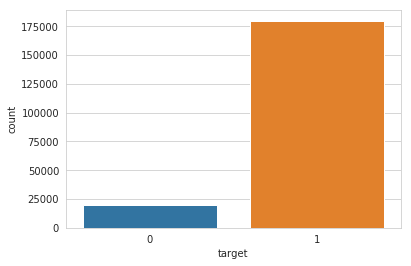

In [12]:
sns.set_style('whitegrid')
sns.countplot(target)
sns.set_style('whitegrid')

<a id=1><pre><b>Classification augment</b></pre></a>

In [13]:
@jit
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

# Build the Light GBM Model

<a id=1><pre><b>Parameters</b></pre></a>

In [14]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [15]:
#kfold = 15
#folds = StratifiedKFold(n_splits=kfold, shuffle=False, random_state=44000)
num_folds = 5
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

<a id=1><pre><b>Run LGBM model</b></pre></a>

In [16]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 100000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.915176	valid_1's auc: 0.901317
[10000]	training's auc: 0.926853	valid_1's auc: 0.90444
[15000]	training's auc: 0.936128	valid_1's auc: 0.904522
Early stopping, best iteration is:
[12284]	training's auc: 0.931212	valid_1's auc: 0.904723
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.917035	valid_1's auc: 0.896198
[10000]	training's auc: 0.928295	valid_1's auc: 0.89889
[15000]	training's auc: 0.93722	valid_1's auc: 0.899196
Early stopping, best iteration is:
[13218]	training's auc: 0.934137	valid_1's auc: 0.899291
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.915834	valid_1's auc: 0.89909
[10000]	training's auc: 0.92744	valid_1's auc: 0.902001
[15000]	training's auc: 0.936627	valid_1's auc: 0.90178
Early stopping, best iteration is:
[11088]	training's auc: 0.92952	valid_1's auc: 0.902

In [17]:
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


 >> CV score: 0.90080 


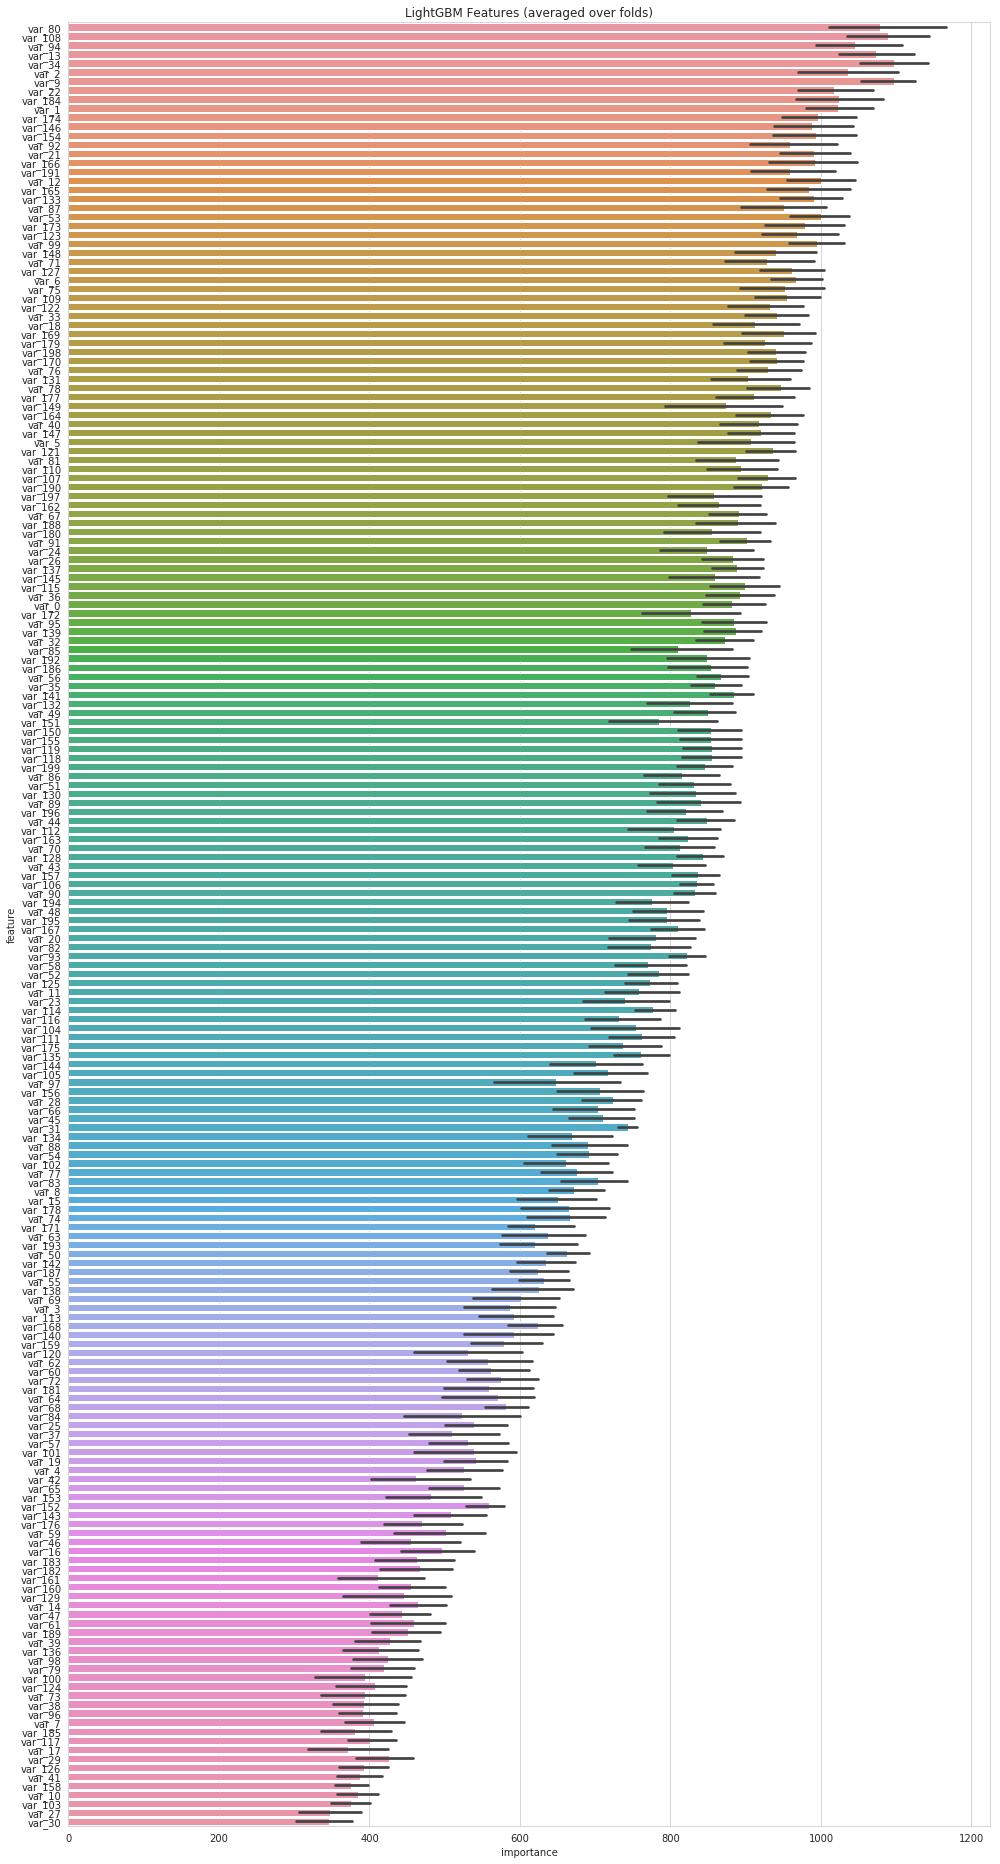

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Submission

In [19]:
submission = pd.DataFrame({"ID_code": test.ID_code.values})
submission["target"] = predictions
submission["target"] = submission["target"].map(lambda x: 1 - x )
submission.to_csv("submission.csv", index=False)

In [20]:
submission.head()

,ID_code,target
0,test_0,0.073512
1,test_1,0.159273
2,test_2,0.112205
3,test_3,0.153373
4,test_4,0.028060
